In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//')

In [3]:
#Importing relevant Packages
import pandas as pd


from pathlib import Path
from weather import enums as weather_enums
import pv_generation
from e2slib.structures import site_schema, datetime_schema
from e2slib.analysis import site
from e2slib.utillib import functions
from pv_generation.utils import functions as pv_functions

## Demo of the pv system code on a test site for 2022

To run a simple example the `pv_generation.main.main()` function can be used to run a dummy site. Further down we'll see how to create a site from scratch.

In [4]:
from pv_generation import main

results = main.main()
results.head()

The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis
The size of a single module is 0.219656729124 kWp or 0.13127314563253012 kWp/m2
The size of a single module is 0.219656729124 kWp or 0.13127314563253012 kWp/m2
No economic data provided. The capital cost is set to the default value.
era5
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists.
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc a

Parameters,additional_site_electricity_demand,electricity_generation
Units,kWh,kWh
2020-01-01 00:00:00+00:00,0.0,-0.04268
2020-01-01 00:30:00+00:00,0.0,-0.04268
2020-01-01 01:00:00+00:00,0.0,-0.04268
2020-01-01 01:30:00+00:00,0.0,-0.04268
2020-01-01 02:00:00+00:00,0.0,-0.04268


Above you can see a plot of the energy generation from the dummy solar PV system for 2020. 

Now we can attribute it to the dummy site energy data we have in the `data > demo` folder to estimate cost savings from import export cost/earnings.

<Axes: title={'center': 'Half-hourly PV Generation (kWh)'}, xlabel='Datetime', ylabel='PV Generation (kWh)'>

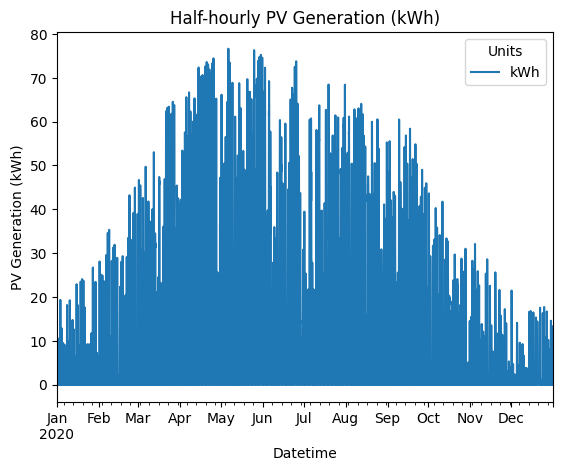

In [5]:
results['electricity_generation'].plot(xlabel='Datetime', ylabel='PV Generation (kWh)', title='Half-hourly PV Generation (kWh)')

## Creating PV system for a Demo Site

### Retrieve weather data for test site

If its the first run, the weather package will be called to generate a weather dataset from one of the external APIs. If there is already locally saved weather data that will be used in it's place.

In [6]:
path_analysis_results = Path.cwd().parent / 'data/pv_analysis'
simulation_year = 2020

site_location = pv_functions.get_location_obj("Demo_site", 
                                        53.514, -1.143, 
                                        114.6,
                                        'UTC')
site_weather = pv_functions.get_weatherdata_obj(site_location, simulation_year, weather_enums.WeatherDataSource.ERA5, path_analysis_results)
site_weather.get_weather_data().head()

The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis
era5
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists.
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc already exists.
/Users/rhysjones/Lib

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse,temp_air
2020-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,3.433685
2020-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,3.479813
2020-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,3.525940
2020-01-01 01:30:00+00:00,0.0,0.0,0.0,0.0,0.0,3.635666
2020-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,3.745392


### Create System and run model

To run the model you require a `pv_generation.PvPanelParam()`, `WeatherData` and `GeoLocation` objects.

- `pv_generation.PvPanelParam` - Holds the data about the PV panels for the system.
- `WeatherData` - Contains the annual weather data for the site from one of the APIs.
- `GeoLocation` - Is used in the `pvlib.modelchain` during model creation.

Once the object is created we can run the model. This runs a simple model predicting energy generation for each half-hourly timestep based on the weather, panel and location data.

In [7]:
# Current system 
pv_param = pv_generation.PvPanelParam()
site_pv_installation = pv_generation.PvInstallation(pv_panel_param=pv_param, 
                                                         weather_data_gen=site_weather, 
                                                         geolocation=site_location)
site_pv_installation.run_model()
site_pv_installation.export_results().head()

The size of a single module is 0.219656729124 kWp or 0.13127314563253012 kWp/m2
era5
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists.
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc already exists.
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv

Parameters,additional_site_electricity_demand,electricity_generation
Units,kWh,kWh
2020-01-01 00:00:00+00:00,0.0,-0.001707
2020-01-01 00:30:00+00:00,0.0,-0.001707
2020-01-01 01:00:00+00:00,0.0,-0.001707
2020-01-01 01:30:00+00:00,0.0,-0.001707
2020-01-01 02:00:00+00:00,0.0,-0.001707


### Grab your site data

The site data we've got contains the half hourly data for energy consumption, import cost and export cost. For our purpose we'll create two new dataframes on for consumption and one for import prices.

In [8]:
#Import file using Pandas
test_site_path = r'../data/demo/demo_elec_data.csv'
test_site = pd.read_csv(test_site_path, delimiter=',')
test_site['time'] = pd.to_datetime(test_site['time'],
                                   format="%d/%m/%Y %H:%M",
                                   utc=True)
test_site = test_site.set_index('time')
# Energy consumption data
site_electricity_data = test_site[['HH Electricity consumption (kWh)']].copy()
site_electricity_data = functions.remove_zero_values(site_electricity_data)
site_electricity_data = functions.fill_missing_data(site_electricity_data)
# Energy price data
site_electricity_prices = test_site[['Electricity Import Price (£/kWh)'
                                     ]].copy()
site_electricity_prices.columns = [
    site_schema.ResultsSchema.IMPORT_ELECTRICITY_PRICES
]

In [9]:
import_elec = (site_electricity_data/site_electricity_data.max()*2).values.flatten() # Normalised import data
export_elec = site_pv_installation.calculate_export_demand(
    import_elec)

<Axes: title={'center': 'Daily imported energy'}, xlabel='Datetime', ylabel='Electricity (kWh)'>

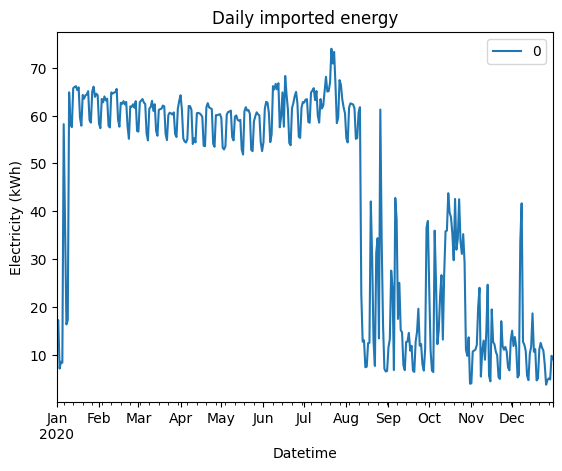

In [10]:
pd.DataFrame(import_elec,
             index=pd.date_range(start='2020-01-01',
                                 periods=len(import_elec),
                                 freq='30T')).resample('D').sum().plot(
                                     xlabel='Datetime',
                                     ylabel='Electricity (kWh)',
                                     title='Daily imported energy')

#### Surplus energy based on demand that could be exported

Using the demo import data and the PV system simulated output we can estimate the surplus energy from generation and plot it.

<Axes: title={'center': 'Daily export energy'}, xlabel='Datetime', ylabel='Electricity (kWh)'>

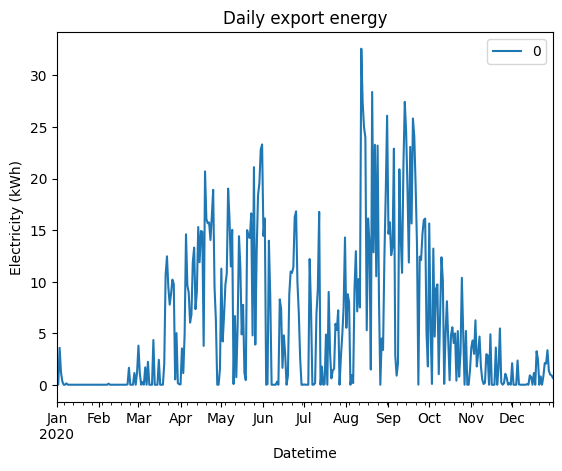

In [11]:
pd.DataFrame(export_elec, index=pd.date_range(start='2020-01-01',
                                 periods=len(export_elec),
                                 freq='30T')).resample('D').sum().plot(
                                     xlabel='Datetime',
                                     ylabel='Electricity (kWh)',
                                     title='Daily export energy')

#### Annual Energy Generation (half-hourly timestep)

<Axes: title={'center': 'Half-hourly PV Generation (kWh)'}, xlabel='Datetime', ylabel='Electricity (kWh)'>

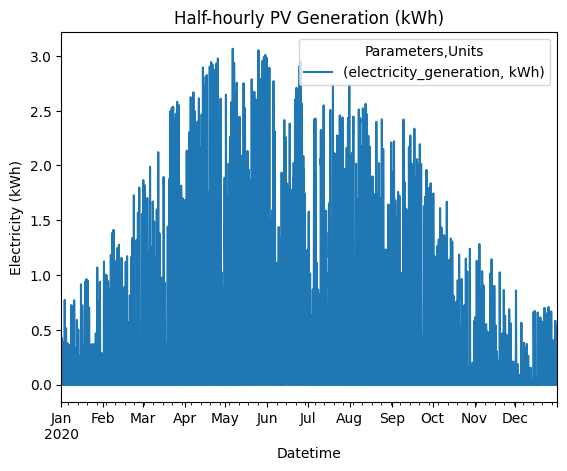

In [12]:
site_pv_installation.results.plot(xlabel='Datetime',
                                  ylabel='Electricity (kWh)',
                                  title='Half-hourly PV Generation (kWh)')

#### Average daily consumption for each month

Everyone knows that solar generation in the northern hemisphere is lower during winter than summer but lets visualise it!

In [13]:
pv_generation_dataf = site_pv_installation.results.copy()
pv_generation_dataf.columns = ['Output']
pv_generation_dataf = functions.add_time_features(pv_generation_dataf)
pv_generation_dataf.head()

,Output,Hour,Day of week,Day of year,Month,Year,Weekday flag,Half-hour,Date,Week,season,season_number
2020-01-01 00:00:00+00:00,-0.001707,0,2,1,1,2020,weekday,0,2020-01-01,1,WINTER,1
2020-01-01 00:30:00+00:00,-0.001707,0,2,1,1,2020,weekday,1,2020-01-01,1,WINTER,1
2020-01-01 01:00:00+00:00,-0.001707,1,2,1,1,2020,weekday,2,2020-01-01,1,WINTER,1
2020-01-01 01:30:00+00:00,-0.001707,1,2,1,1,2020,weekday,3,2020-01-01,1,WINTER,1
2020-01-01 02:00:00+00:00,-0.001707,2,2,1,1,2020,weekday,4,2020-01-01,1,WINTER,1


<Axes: xlabel='Half-hour'>

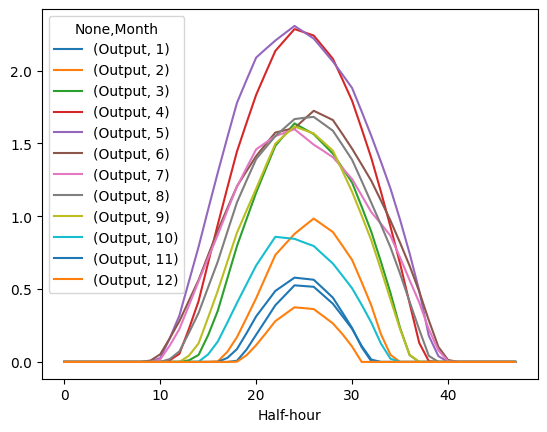

In [14]:
pv_generation_dataf.groupby([datetime_schema.DateTimeSchema.MONTH, datetime_schema.DateTimeSchema.HALFHOUR]).agg({'Output':'mean'}).unstack(0).plot()

### Avoiding export

Due to the low price of exporting fuel and the work required to alter contracts with providers it is often prefered to avoid exporting energy back to the grid. Due to this we've added a function `size_pv_system_for_no_export()` that takes the sites annual energy consumption as input to estimate how big of a solar system can be added to the site in consideration of their current energy consumption.

In [15]:
max_size_pv_system = site_pv_installation.size_pv_system_for_no_export(site_electricity_data)
print(f'The max PV system that can be installed to avoid export is {max_size_pv_system:.1f} kW')

era5
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surface_net_solar_radiation_2020.nc already exists.
Check if /Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc already exists...
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_2m_temperature_2020.nc already exists.
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation/data/pv_analysis/weather_data/Demo_site_netcdf_data/Demo_site_surfac

## Create Site object

Creating a site object allows you to view the results of the PV installation modeling. You can add a number of different pv objects in a list to the site object, this is helpful if you had a site that had more than one roof, roofs of different sizes, different angles etc.

The returing resulting dataf has additional columns compared to the pv system results.

- `site_import_electricity_demand` - The new import energy demand with the PV system added.
- `initial_site_electricity_demand` - Is the original site import demand without the PV system.
- `self-consumed_electricity` - Is the amount of self consumed energy for that timestep.

In [16]:
test_site = site.Site("test", site_location, [site_pv_installation], site_electricity_data)
test_site.export_results()

The results will be stored at:
/Users/rhysjones/Library/CloudStorage/GoogleDrive-rhys.jones@e2s.energy/My Drive/pv-generation


Parameters,site_import_electricity_demand,site_export_electricity_demand,electricity_generation,additional_site_electricity_demand,initial_site_electricity_demand,self-consumed_electricity
Units,kWh,kWh,kWh,kWh,kWh,kWh
2020-01-01 00:00:00+00:00,51.701707,-0.0,-0.001707,0.0,51.7,-0.001707
2020-01-01 00:30:00+00:00,56.001707,-0.0,-0.001707,0.0,56.0,-0.001707
2020-01-01 01:00:00+00:00,56.001707,-0.0,-0.001707,0.0,56.0,-0.001707
2020-01-01 01:30:00+00:00,51.401707,-0.0,-0.001707,0.0,51.4,-0.001707
2020-01-01 02:00:00+00:00,54.901707,-0.0,-0.001707,0.0,54.9,-0.001707
...,...,...,...,...,...,...
2020-12-31 21:30:00+00:00,32.101707,-0.0,-0.001707,0.0,32.1,-0.001707
2020-12-31 22:00:00+00:00,27.601707,-0.0,-0.001707,0.0,27.6,-0.001707
2020-12-31 22:30:00+00:00,33.901707,-0.0,-0.001707,0.0,33.9,-0.001707


Summing the results we can see that the approximate 7 MWh has been mostly self-consumed by the demo site.

In [17]:
test_site.export_results().sum()

Parameters                          Units
site_import_electricity_demand      kWh      8.048631e+06
site_export_electricity_demand      kWh      0.000000e+00
electricity_generation              kWh      7.387160e+03
additional_site_electricity_demand  kWh      0.000000e+00
initial_site_electricity_demand     kWh      8.056018e+06
self-consumed_electricity           kWh      7.387160e+03
dtype: float64